# <center> **Insights for a Strategic Merger in the OTT Domain** </center>

## <center> **Import Libraries** </center>

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

## <center> **Import Data** </center>

In [2]:
load_dotenv()

db_user = os.environ.get("DB_USER")
db_password = os.environ.get("DB_PASSWORD")
db_host = os.environ.get("DB_HOST")

js_db_name = os.environ.get("JS_DB_NAME")
lc_db_name = os.environ.get("LC_DB_NAME")

# Use the credentials to connect to the database

# Database connection string
js_conn_string = f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{js_db_name}"
lc_conn_string = f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{lc_db_name}"

# Create engine
js_engine = create_engine(js_conn_string)
lc_engine = create_engine(lc_conn_string)

In [3]:
# Jotstar Tables
js_content_consumption = pd.read_sql_query("SELECT * FROM content_consumption", js_engine)
js_contents = pd.read_sql_query("SELECT * FROM contents", js_engine)
js_subscribers = pd.read_sql_query("SELECT * FROM subscribers", js_engine, 
                                   parse_dates={"subscription_date":'%Y-%m-%d', "last_active_date":'%Y-%m-%d', "plan_change_date":'%Y-%m-%d'})

In [4]:
# LioCinema Tables
lc_content_consumption = pd.read_sql_query("SELECT * FROM content_consumption", lc_engine)
lc_contents = pd.read_sql_query("SELECT * FROM contents", lc_engine)
lc_subscribers = pd.read_sql_query("SELECT * FROM subscribers", lc_engine, 
                                   parse_dates={"subscription_date":'%Y-%m-%d', "last_active_date":'%Y-%m-%d', "plan_change_date":'%Y-%m-%d'})

In [5]:
plan_order = ["Free", "Basic", "Premium"]

## <center> **Data Transformation** </center>

#### **1. Standardizing plans**

JotStar VIP -> Basic

In [6]:
# Standardizing plans: Mapping VIP plan to Basic 
plan_mapping = {'Free': 'Free', 'VIP':'Basic', 'Premium':'Premium'}
js_subscribers['subscription_plan'] = js_subscribers['subscription_plan'].replace(plan_mapping)
js_subscribers['new_subscription_plan'] = js_subscribers['new_subscription_plan'].replace(plan_mapping)

#### **2. Adding Status to Subscribers**

Status: Active/Inactive 

In [7]:
# Define user status
js_subscribers['status'] = js_subscribers['last_active_date'].isnull().map({True: 'Active', False: 'Inactive'})
lc_subscribers['status'] = lc_subscribers['last_active_date'].isnull().map({True: 'Active', False: 'Inactive'})

## <center> **Content Consumption - Watch Time Analysis** </center>

#### **1. Average content consumption by device type**

In [8]:
def watch_time_distribution(ax, data, title):
    """Plots a bar chart for the given data distribution."""
    data.plot(kind='bar', ax=ax)
    for container in ax.containers:
        ax.bar_label(container)
    
    ax.set_title(title)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('')
    ax.tick_params(rotation=0)

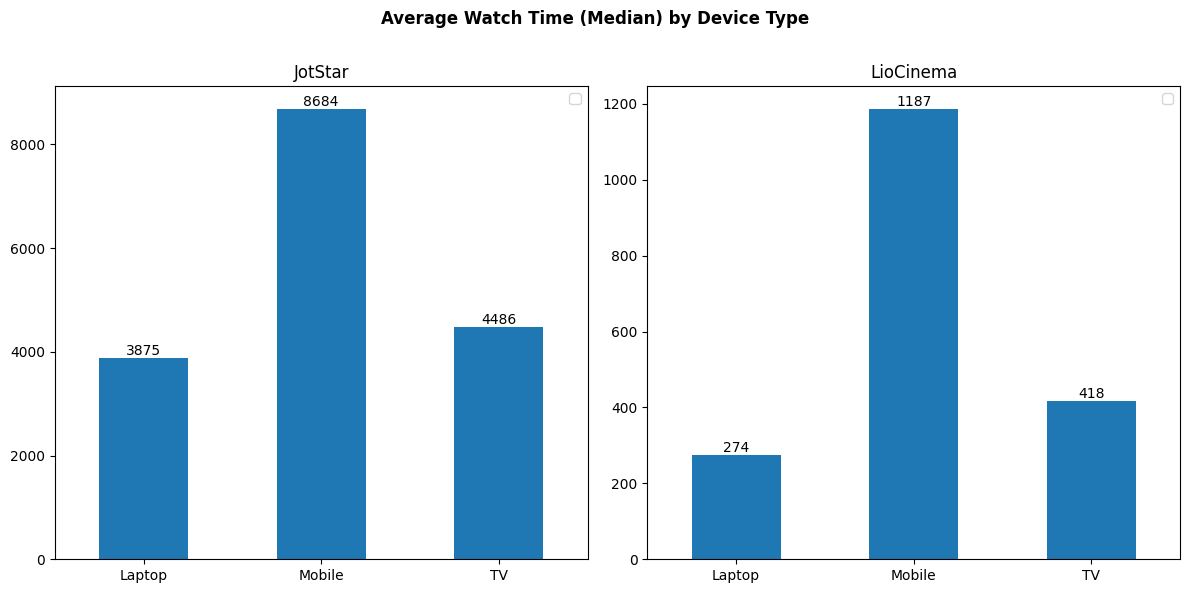

In [9]:
# Average Watch Time by Device Type 

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

watch_time_distribution(ax[0], js_content_consumption.groupby("device_type")["total_watch_time_mins"].median(), 'JotStar')
watch_time_distribution(ax[1], lc_content_consumption.groupby("device_type")["total_watch_time_mins"].median(), 'LioCinema')

fig.suptitle("Average Watch Time (Median) by Device Type", fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Mobile is the Dominant Device: For both Jotstar and LioCinema, mobile has the most content consumption when compared to TV and laptops
- Jotstar Has Higher Engagement Overall: In all three devices, Jotstar has much higher average content consumption than LioCinema
- Jotstar has a considerably larger or more active user base compared to LioCinema
- LioCinema may require aggressive strategies (promotions, collaborations, or unique content) to catch up

#### **2. Heavy Watchers**
- Users with high total_watch_time_mins compared to the overall or device-specific average.
- A heavy watcher could be someone who watches a lot spread across multiple short sessions rather than long, continuous sessions.

Heavy watchers → High total watch time over any period (could be spread out or in short bursts)

Binge-watchers → Watch for very long sessions in a single sitting

**Percentile-Based Approach**
- Simply comparing to the overall or device-specific average may not effectively distinguish heavy watchers, as the average could be skewed by a few extreme values.
- Using the 95th percentile (or another high threshold) ensures identifying the topmost engaged users rather than just those slightly above average.
- User is a heavy watcher if they exceed the 95th percentile on **atleast one device**

In [10]:
def find_heavy_watchers(data):
    pivoted_data = data.pivot(index='user_id', columns=['device_type'], values=['total_watch_time_mins'])
    pivoted_data.columns = pivoted_data.columns.droplevel(0)

    watch_time_treshold_per_device_type = pivoted_data.quantile(q=0.95)
    
    pivoted_data['heavy_watcher'] = (pivoted_data > watch_time_treshold_per_device_type).any(axis=1)
    
    return pivoted_data[pivoted_data['heavy_watcher']].shape[0]

In [11]:
print('Platform-Wise Heavy Watchers')
print(f'Jotstar: {find_heavy_watchers(js_content_consumption)}')
print(f'LioCinema: {find_heavy_watchers(lc_content_consumption)}')

Platform-Wise Heavy Watchers
Jotstar: 3371
LioCinema: 9919


#### **3. Content Consumption differs based on user demographics**

In [12]:
columns = ['age_group', 'city_tier', 'subscription_plan', 'device_type', 'status', 'total_watch_time_mins']
js_merged = pd.merge(js_content_consumption, js_subscribers, on='user_id')[columns]
lc_merged = pd.merge(lc_content_consumption, lc_subscribers, on='user_id')[columns]

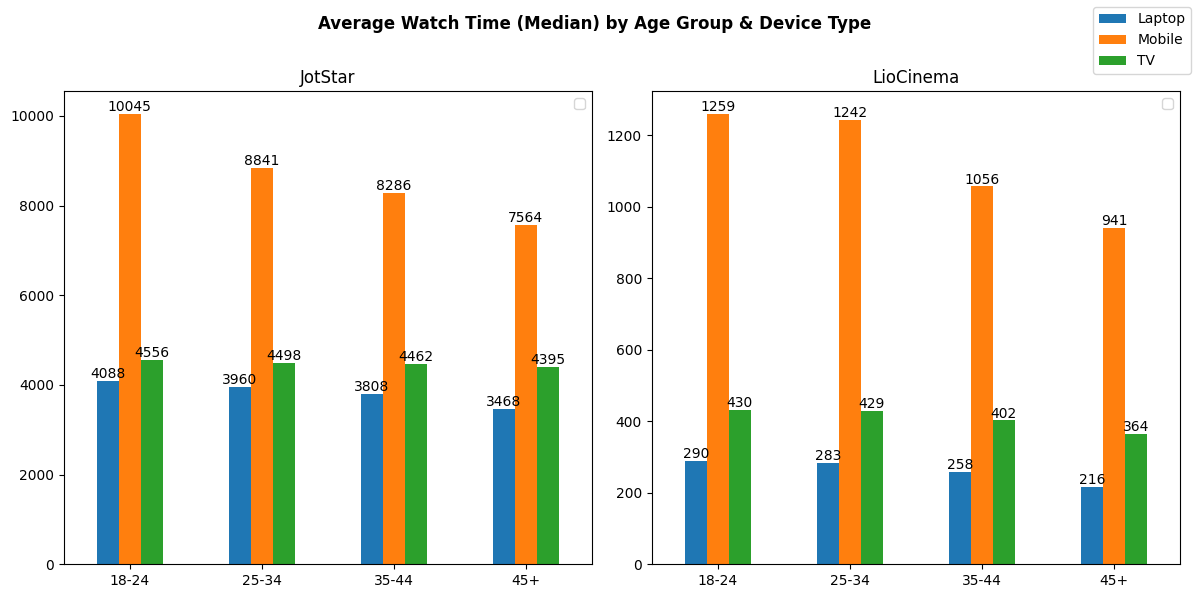

In [13]:
# Average Watch Time by Age Group & Device Type
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

watch_time_distribution(ax[0], js_merged.groupby(['age_group', 'device_type'])['total_watch_time_mins'].median().round().unstack(level=1), 'JotStar')
watch_time_distribution(ax[1], lc_merged.groupby(['age_group', 'device_type'])['total_watch_time_mins'].median().round().unstack(level=1), 'LioCinema')

fig.suptitle("Average Watch Time (Median) by Age Group & Device Type", fontweight='bold')
fig.legend(['Laptop', 'Mobile', 'TV'])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

On both platforms
- The 18-24 age group consumes the most content across all three device
- Mobile is the preferred device for all ages
- Content Consumption decreases with age on all devices
- Television Consumption is more evenly distributed among age groups

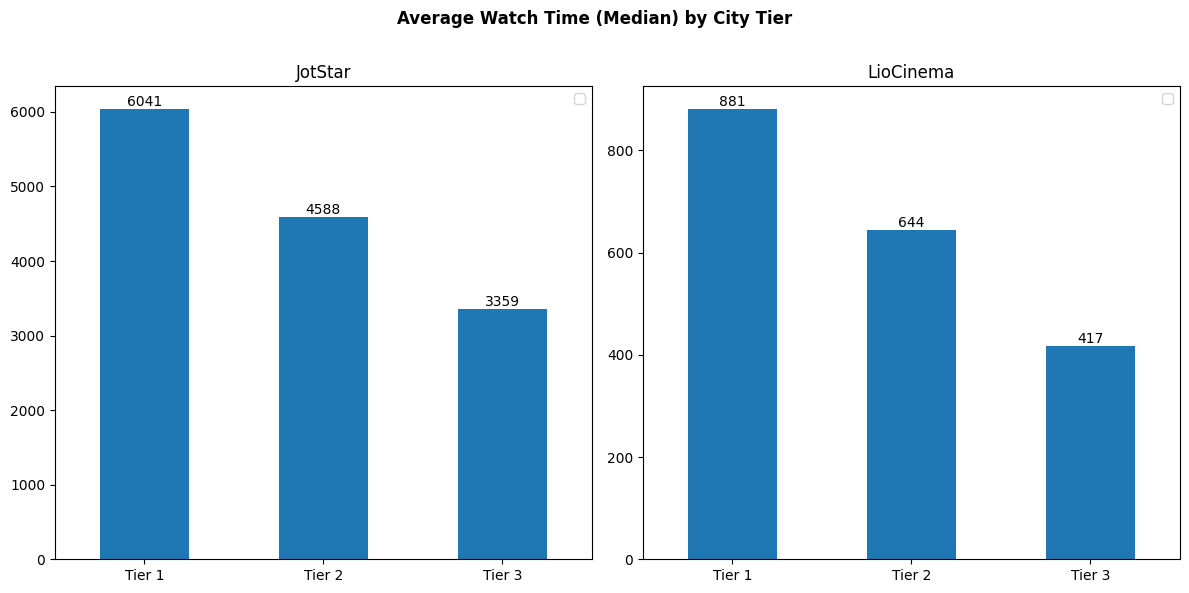

In [14]:
# Average Watch Time by City Tier
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

watch_time_distribution(ax[0], js_merged.groupby(['city_tier'])['total_watch_time_mins'].median().round(), 'JotStar')
watch_time_distribution(ax[1], lc_merged.groupby(['city_tier'])['total_watch_time_mins'].median().round(), 'LioCinema')

fig.suptitle("Average Watch Time (Median) by City Tier", fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

On both platforms
- Higher Content Consumption in Tier-1 Cities
- Content Consumption decreases as we move to lower-tier cities

In [15]:
def avg_watch_time_subscription_plan(data):
    df = data.groupby(['subscription_plan'])['total_watch_time_mins'].median().round()
    df.index = pd.Categorical(df.index, plan_order, ordered=True) # Change index to categorical type
    df.sort_index(inplace=True) # Sort index
    return df

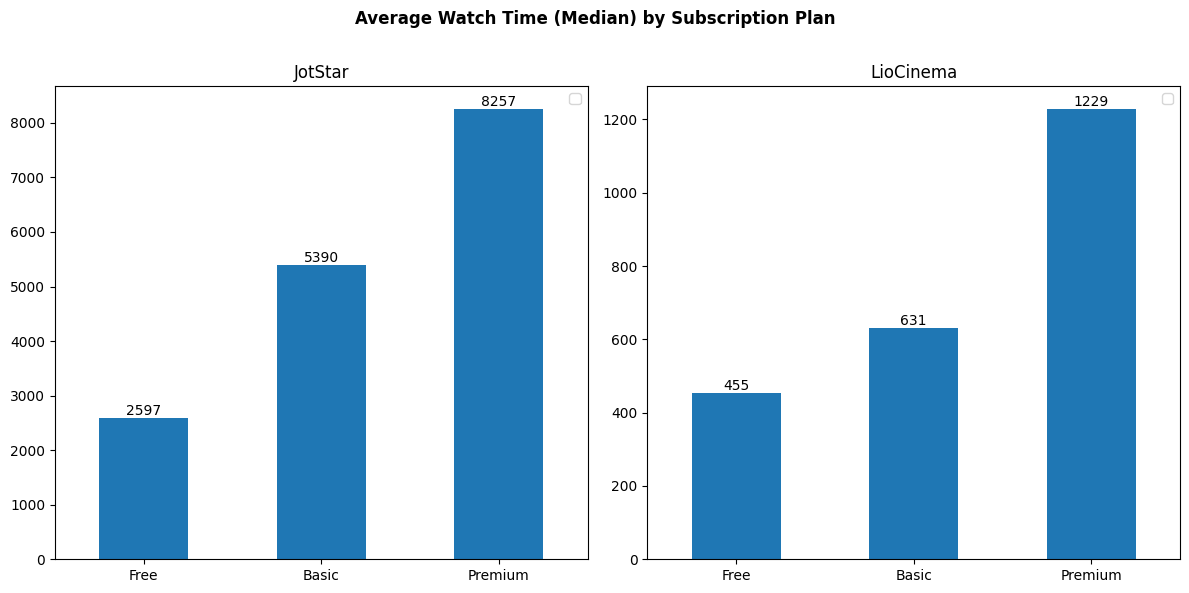

In [16]:
# Average Watch Time by Subscription Plan
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

watch_time_distribution(ax[0], avg_watch_time_subscription_plan(js_merged), 'JotStar')
watch_time_distribution(ax[1], avg_watch_time_subscription_plan(lc_merged), 'LioCinema')

fig.suptitle("Average Watch Time (Median) by Subscription Plan", fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Premium consumers watch much more content than Free and Basic on both platforms because they have access to unique content, ad-free experiences, and greater streaming quality
-  Jotstar users have far higher watch time across all plans than LioCinema because they have more captivating or exclusive content

## <center> **Content Library Comparison** </center>

In [17]:
def content_distribution(ax, data, title):
    """Plots a horizontal bar chart for the given data distribution."""
    data.plot(kind='barh', ax=ax)
    for container in ax.containers:
        ax.bar_label(container)
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('')
    ax.set_xticklabels('')
    ax.tick_params(rotation=0)
    # ax.invert_yaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])

#### **1. Popular Content Categories (Genre & Content Type Analysis)**

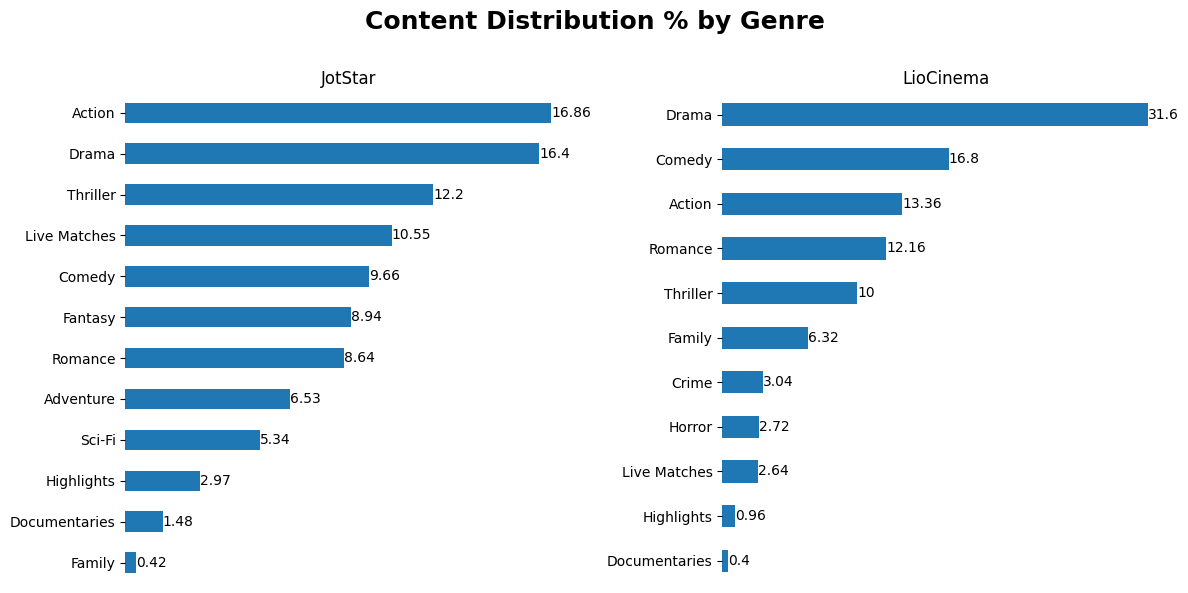

In [18]:
# Content Distribution % by Genre
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

content_distribution(ax[0], round((js_contents['genre'].value_counts(normalize=True)*100), 2).sort_values(), 'JotStar')
content_distribution(ax[1], round((lc_contents['genre'].value_counts(normalize=True)*100), 2).sort_values(), 'LioCinema')

fig.suptitle("Content Distribution % by Genre", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Jotstar has a more diversified content mix, with a strong concentration on action, drama, and thriller, as well as a major amount dedicated to Live Matches, making it an excellent choice for audiences
- LioCinema attracts to typical TV audiences, emphasizing Drama, Romance, Action, and Comedy, making it ideal for binge-watchers and family entertainment

#### **2. Content Type Distribution**

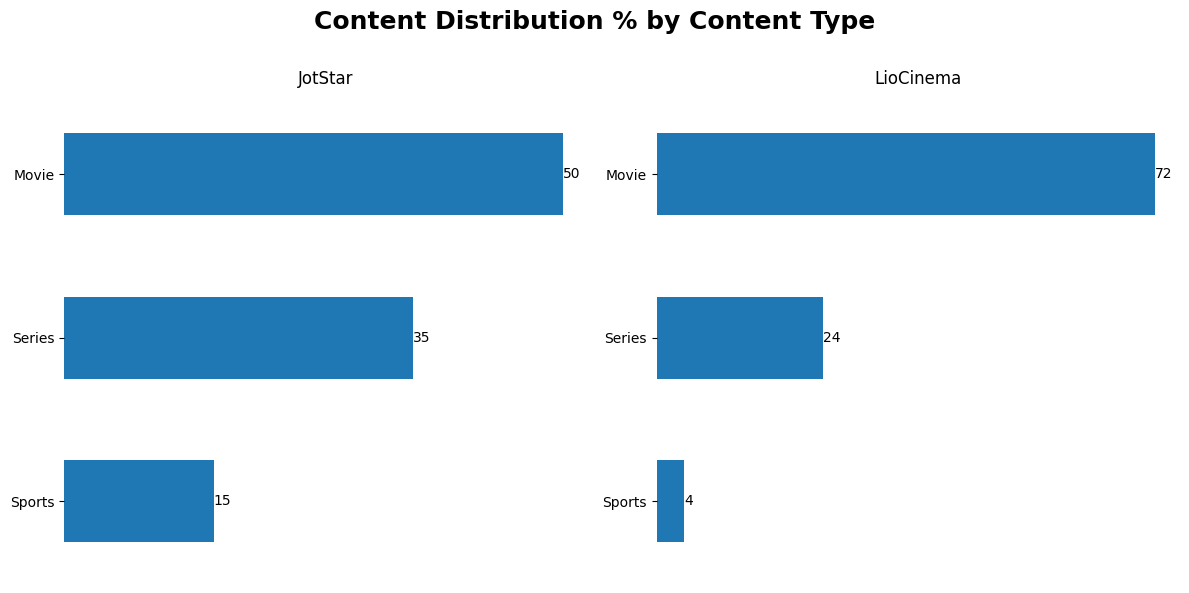

In [19]:
# Content Distribution % by Content Type
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

content_distribution(ax[0], round((js_contents['content_type'].value_counts(normalize=True)*100)).sort_values(), 'JotStar')
content_distribution(ax[1], round((lc_contents['content_type'].value_counts(normalize=True)*100)).sort_values(), 'LioCinema')

fig.suptitle("Content Distribution % by Content Type", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Jotstar offers a wide mix of movies, series, and sports, while LioCinema prioritizes movies over series and sports, reflecting a classic film-centric strategy

#### **3. Genre vs. Average Run-Time Analysis**

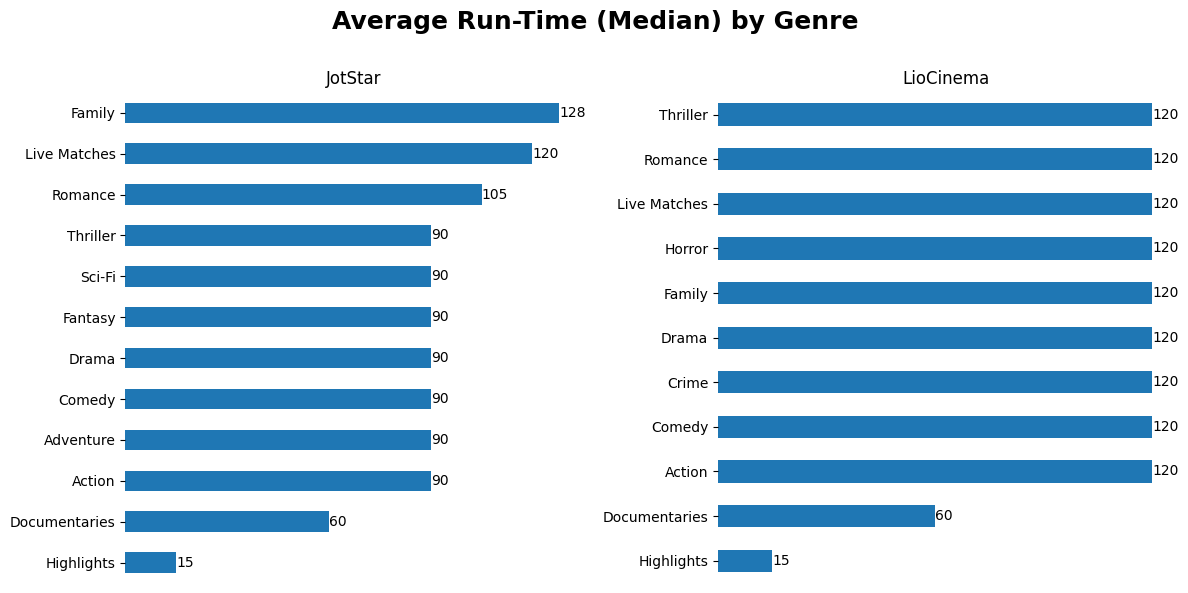

In [20]:
# Genre vs. Average Run-Time Analysis
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

content_distribution(ax[0], js_contents.groupby('genre')['run_time'].median().round().sort_values(), 'JotStar')
content_distribution(ax[1], lc_contents.groupby('genre')['run_time'].median().round().sort_values(), 'LioCinema')

fig.suptitle("Average Run-Time (Median) by Genre", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- LioCinema has a fixed run-time of 120 minutes for most genres. It appears to prioritize full-length cinematic experiences, making it appealing to users who enjoy deep, long-form storytelling
- Jotstar has more flexibility in run-times, with genres typically about 90 minutes and lengthier durations for Romance, Live Matches, and Family

#### **4. Language-Wise Content Distribution**

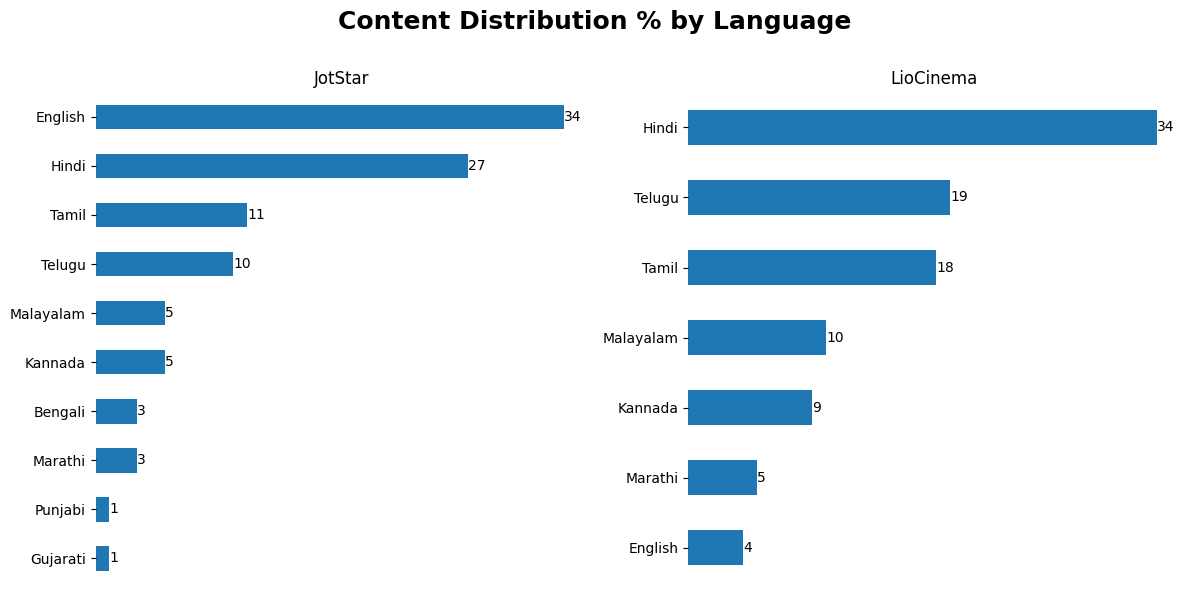

In [21]:
# Content Distribution % by Language
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

content_distribution(ax[0], round((js_contents['language'].value_counts(normalize=True)*100)).sort_values(), 'JotStar')
content_distribution(ax[1], round((lc_contents['language'].value_counts(normalize=True)*100)).sort_values(), 'LioCinema')

fig.suptitle("Content Distribution % by Language", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Jotstar is a worldwide accessible site with a large presence in English and Hindi. LioCinema is locally focused on Indian languages, with Telugu (19%) and Tamil (18%) combined nearly equal to Hindi (34%)

## <center> **Subscribers Insights - User Demographics** </center>

In [22]:
def subscriber_distribution(ax, data, title):
    """Plots a bar chart for the given data distribution."""
    data.plot(kind='bar', ax=ax)
    for container in ax.containers:
        ax.bar_label(container)
    
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(rotation=0)

#### **1. Subscriber Acquisition Trends**

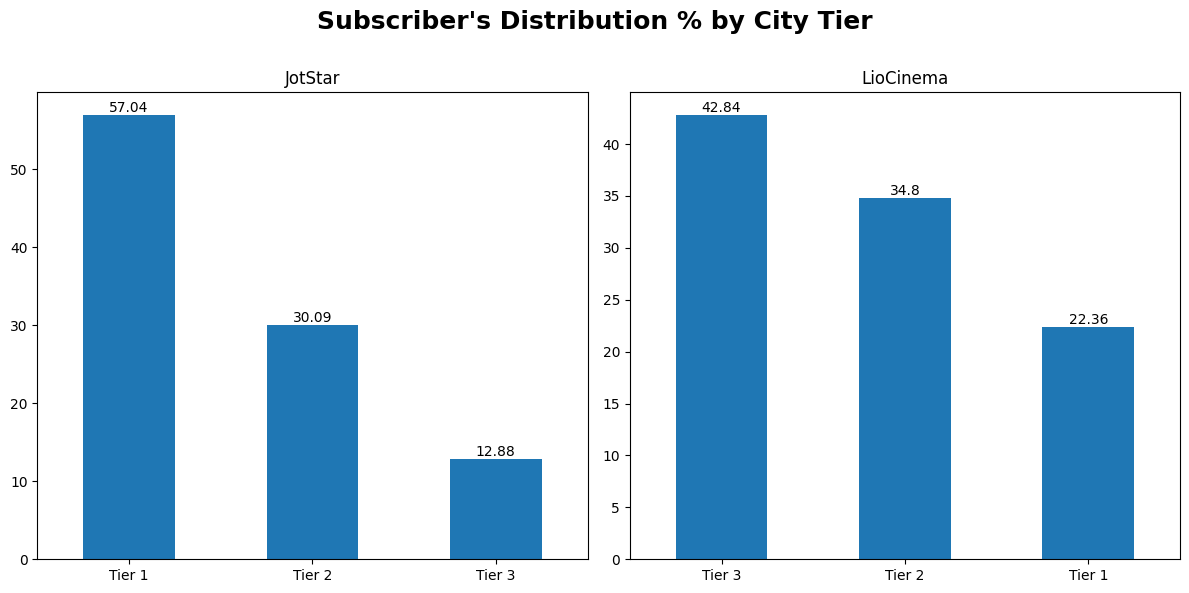

In [23]:
# Subscriber's Distribution % by City Tier
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

subscriber_distribution(ax[0], round(js_subscribers['city_tier'].value_counts(normalize=True)*100, 2), 'JotStar')
subscriber_distribution(ax[1], round(lc_subscribers['city_tier'].value_counts(normalize=True)*100, 2), 'LioCinema')

fig.suptitle("Subscriber's Distribution % by City Tier", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- The majority of Jotstar's subscribers reside in Tier 1 cities, with Tier 2 and Tier 3 cities following
- Given its significant presence in Tier 1 cities, Jotstar suggests that its plans are more expensive or emphasize high-speed internet, cutting-edge infrastructure, or premium content
- On the other hand, LioCinema follows a contrary pattern (Reverse), indicating that it is likely targeting price-sensitive customers with more reasonably priced plans and producing more regional content

In [24]:
def month_wise_subscribers(ax, data, title):
    monthly_subscribers = data.groupby(data["subscription_date"].dt.to_period('M')).size()

    x_values = monthly_subscribers.index.strftime('%b')
    y_values = monthly_subscribers.values
    
    # Create the line plot
    ax.plot(x_values, y_values, marker='o', linestyle='-')
    
    # Add data labels
    for x, y in zip(x_values, y_values):
        ax.text(x, y, str(y), ha='center', va='bottom', fontsize=10, color='black')
    
    
    # Formatting
    ax.set_title(title, fontsize=14)
    ax.grid(True)

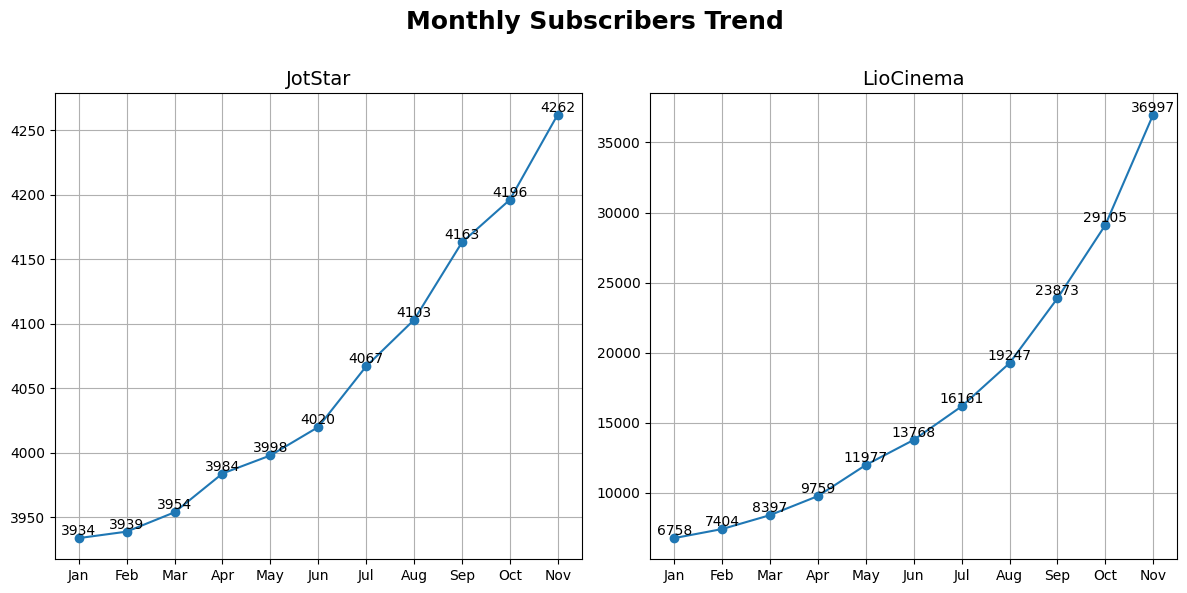

In [25]:
# Monthly Subscribers
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

month_wise_subscribers(ax[0], js_subscribers, 'JotStar')
month_wise_subscribers(ax[1], lc_subscribers, 'LioCinema')

fig.suptitle("Monthly Subscribers Trend", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Over a period of 11 months, Jotstar's subscriber base increased from 3,934 to 4,262, representing a slow but consistent increase of about 8.3%
- LioCinema's rapid rise from 6,758 to 36,997 in 11 months can be due to its expansion into Tier 2 and Tier 3 cities, as well as its affordable pricing and regional content

#### **2. Demographic Variations**

In [26]:
def subscription_plan_by_age_group(ax, data, title):
    df = round(data[['age_group', 'subscription_plan']].value_counts()/data.groupby('age_group').size()*100, 2).unstack(level=0)
    df.index = pd.Categorical(df.index, plan_order, ordered=True)
    df.sort_index(inplace=True)
    df.unstack().unstack().plot(kind='bar', stacked=True, ax=ax)

    # Data labels
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

    # Formatting
    ax.set_title(title)
    ax.set_xlabel("")
    ax.tick_params(rotation=0)
    ax.legend('') 

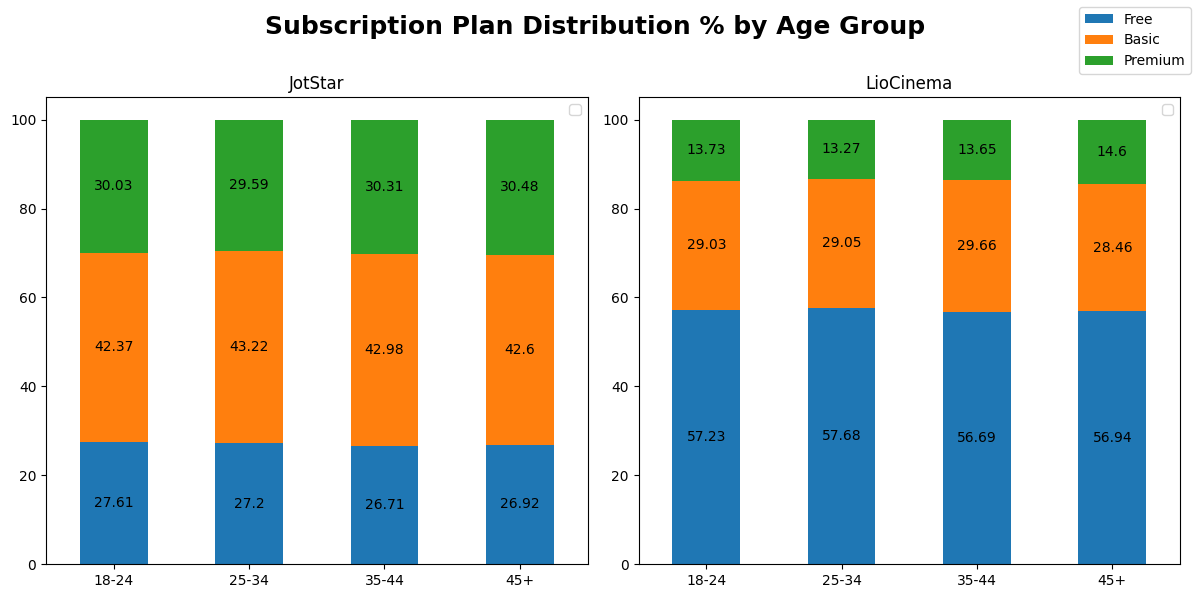

In [27]:
# Subscription Plan Distribution % by Age Group
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

subscription_plan_by_age_group(ax[0], js_subscribers, 'JotStar')
subscription_plan_by_age_group(ax[1], lc_subscribers, 'LioCinema')

fig.suptitle("Subscription Plan Distribution % by Age Group", fontsize=18, fontweight='bold')
fig.legend(['Free', 'Basic', 'Premium'])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Across both the platforms, age groups show very similar trends in plan adoption
- Across all age groups, LioCinema has a significantly higher percentage of users on the Free plan, suggesting that the company prioritizes market penetration over monetization
- The JotStar VIP plan (equal to Basic) is widely adopted across all age groups, with a rate of approximately 42-43%
- Compared to LioCinema, JotStar has a larger percentage of Premium users (around 30%)

#### **3. Paid Users Distribution**

In [28]:
def paid_user_distribution(ax, data, title):
    paid_subscribers = data[data['subscription_plan'] != 'Free']
    round(paid_subscribers['subscription_plan'].value_counts(normalize=True)*100, 2).plot(kind='bar', ax=ax)

    # Data Labels
    for container in ax.containers:
        ax.bar_label(container)

    # Formatting
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(rotation=0)

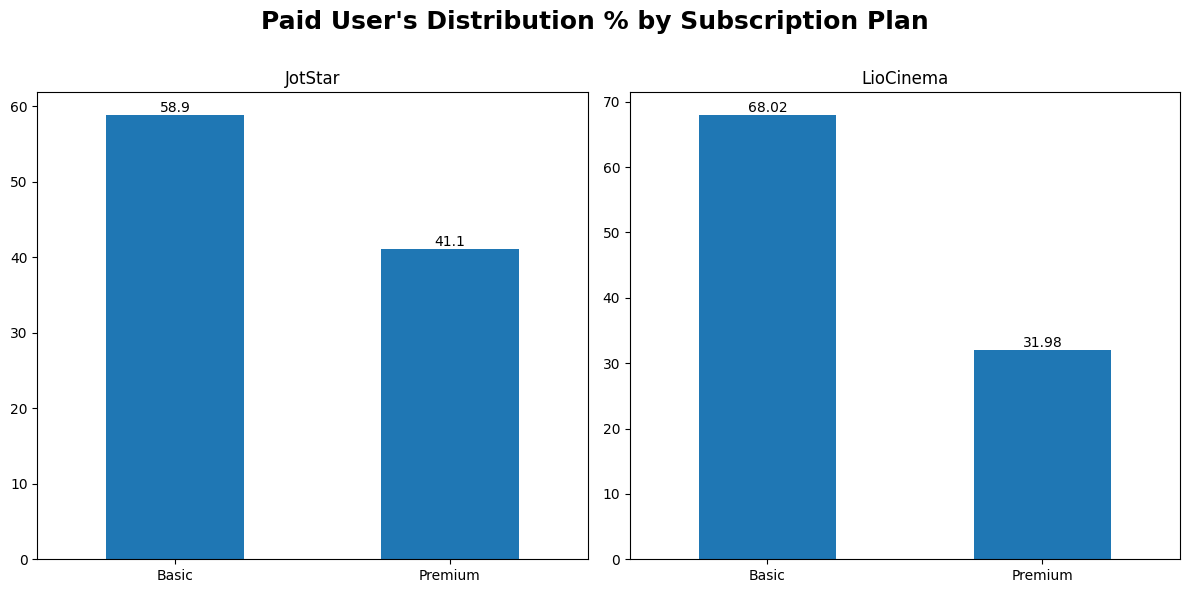

In [29]:
# Paid User Distribution % by Subscription Plan
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

paid_user_distribution(ax[0], js_subscribers, 'JotStar')
paid_user_distribution(ax[1], lc_subscribers, 'LioCinema')

fig.suptitle("Paid User's Distribution % by Subscription Plan", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- JotStar has a more balanced distribution of Basic and Premium users, likely due to stronger premium content and feature differentiation, whereas LioCinema has a lower premium adoption rate

In [30]:
def premium_user_distribution(ax, data, title):
    premium_subscribers = data[data['subscription_plan'] == 'Premium']
    round(premium_subscribers['city_tier'].value_counts(normalize=True)*100, 2).plot(kind='bar', ax=ax)

    # Data Labels
    for container in ax.containers:
        ax.bar_label(container)

    # Formatting
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(rotation=0)

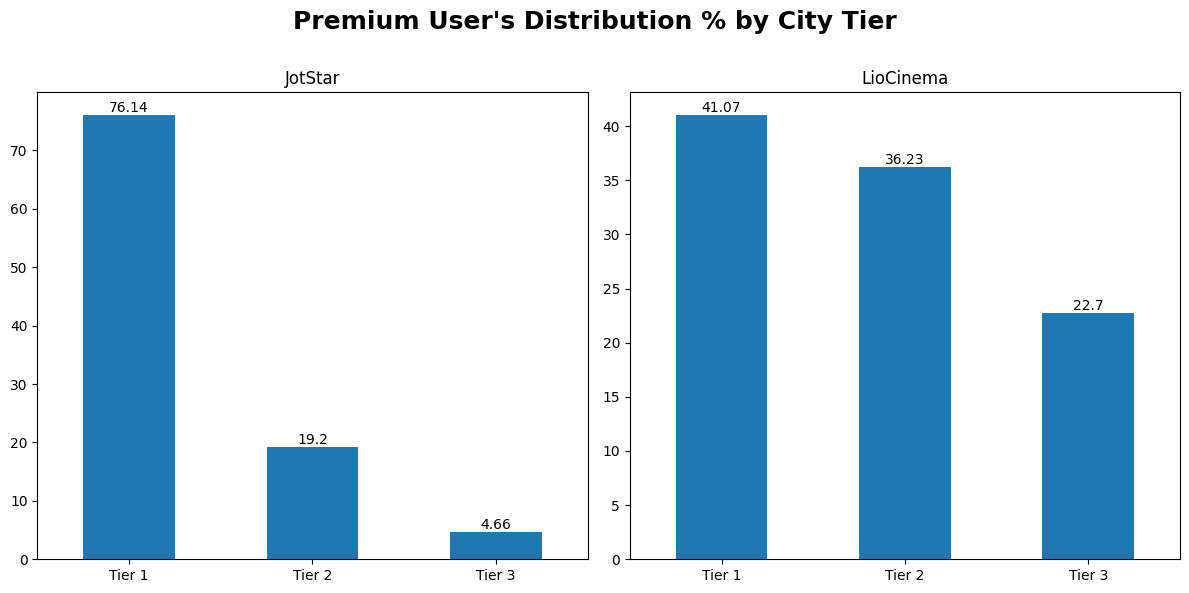

In [31]:
# Premium User Distribution % by City Tier
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

premium_user_distribution(ax[0], js_subscribers, 'JotStar')
premium_user_distribution(ax[1], lc_subscribers, 'LioCinema')

fig.suptitle("Premium User's Distribution % by City Tier", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- JotStar's premium strategy is highly urban-focused and targets high-income users
- 
LioCinema's premium strategy is more inclusive, catering to semi-urban and rural users alike. This may be due to inexpensive pricing and regional conten.

#### **4. User Engagement Category**

In [32]:
# Users Engagement days_since_last_active

from datetime import datetime
# Assume today is Dec 31, 2024
today = datetime(2024, 12, 31)

def categorize_engagement(days):
    if pd.isna(days):  
        return 'Active'
    elif days <= 30:
        return 'Highly Engaged'
    elif days <= 90:
        return 'Moderately Engaged'
    else:
        return 'Dormant'

def user_engagement_category(ax, data, title):
    data['days_since_last_active'] = (today - data['last_active_date']).dt.days + 1
    data['engagement_category'] = data['days_since_last_active'].apply(categorize_engagement)
    
    # Plot
    round((data['engagement_category'].value_counts(normalize=True)*100), 2).plot(kind='bar', ax=ax)

    # Data Labels
    for container in ax.containers:
        ax.bar_label(container)

    # Formatting
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(rotation=0)

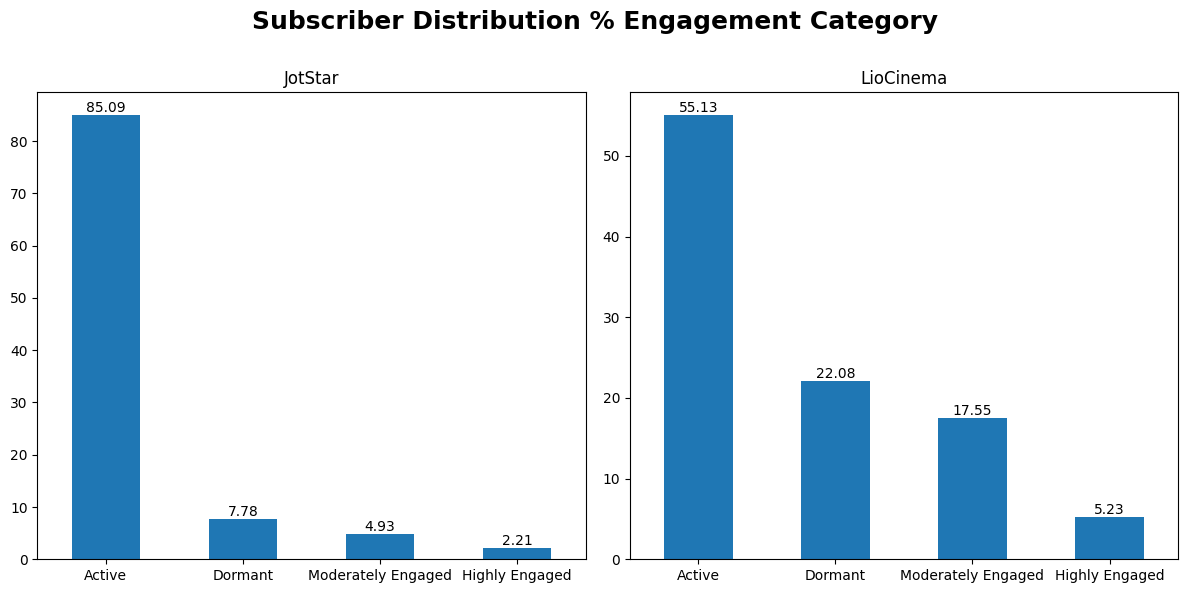

In [33]:
# Subscriber Distribution % Engagement Category
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

user_engagement_category(ax[0], js_subscribers, 'JotStar')
user_engagement_category(ax[1], lc_subscribers, 'LioCinema')

fig.suptitle("Subscriber Distribution % Engagement Category", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Jotstar has a larger percentage of active users and a community of loyal active subscribers
- The large percentage of dormant users on LioCinema is probably caused by its high user churn and dependence on free users
- There are more moderately and highly engaged users on LioCinema, but they haven't committed completely

## <center> **Upgrade & Downgrade Patterns** </center> 

### **Upgrade Patterns: Factors Influencing Subscription Upgrades**

#### **1. Age Group & City Tier Influence on Upgrades**

In [34]:
# Plan hierarchy
plan_hierarchy = {'Free': 1, 'Basic': 2, 'Premium': 3}

def upgrade_analysis(ax, data, title):
    # Users who upgraded
    df_upgraded = data[(data['plan_change_date'].notna()) & 
        (data['new_subscription_plan'].map(plan_hierarchy) > data['subscription_plan'].map(plan_hierarchy))]

    # Count total users per segment
    total_users_per_segment = data.groupby(['age_group', 'city_tier']).size().reset_index()
    total_users_per_segment.columns = ['age_group', 'city_tier', 'total_users']
    
    # Count upgraded users per segment
    upgraded_users_per_segment = df_upgraded.groupby(['age_group', 'city_tier']).size().reset_index()
    upgraded_users_per_segment.columns = ['age_group', 'city_tier', 'upgraded_users']

    # Merge data to get total and upgraded user counts
    upgrade_analysis = pd.merge(total_users_per_segment, upgraded_users_per_segment, on=['age_group', 'city_tier'])
    upgrade_analysis['upgrade_rate'] = round((upgrade_analysis['upgraded_users']/upgrade_analysis['total_users']) * 100, 2)
    upgrade_analysis.set_index(['age_group', 'city_tier'], inplace=True)

    sns.heatmap(upgrade_analysis['upgrade_rate'].unstack(), annot=True, fmt='', cmap='Greens', linewidths=0.5, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(rotation=0)

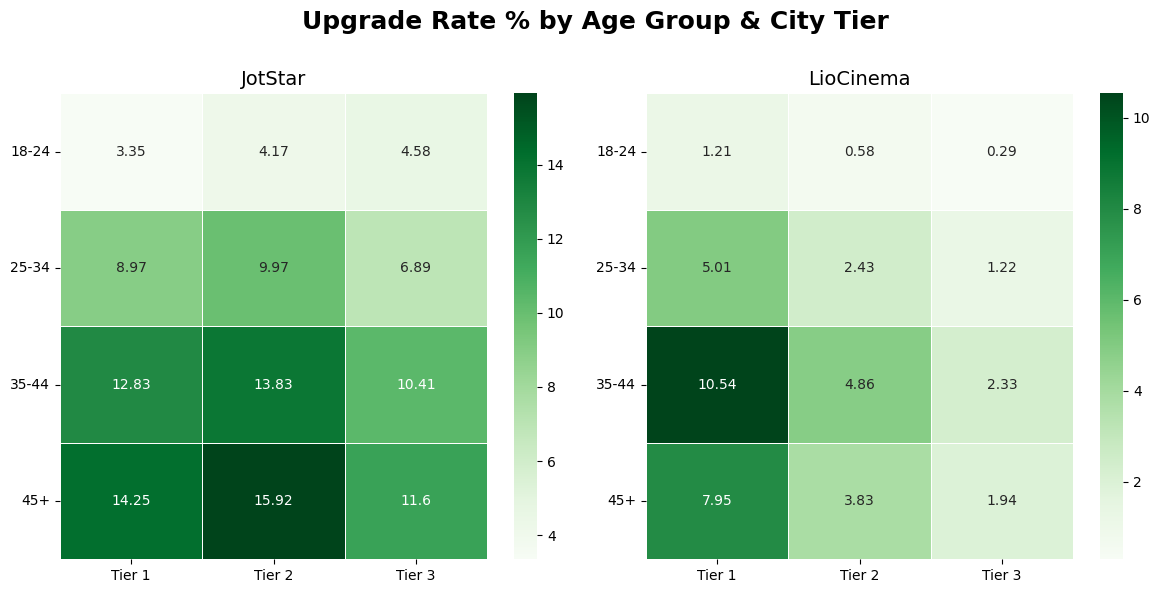

In [35]:
# Upgrade Rate % by Age Group & City Tier
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

upgrade_analysis(ax[0], js_subscribers, 'JotStar')
upgrade_analysis(ax[1], lc_subscribers, 'LioCinema')

fig.suptitle("Upgrade Rate % by Age Group & City Tier", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Upgrade rates increases with age, particularly in Tier 1 and Tier 2 cities for the majority of age groups
- JotStar consistently outperformed LioCinema across all demographics

#### **2. Upgrade Subscription Transition %**

In [36]:
def upgrade_subscription_plan_transition(ax, data, title):
    df_upgraded = data[(data['plan_change_date'].notna()) & 
        (data['new_subscription_plan'].map(plan_hierarchy) > data['subscription_plan'].map(plan_hierarchy))]
    
    sns.heatmap(
        round((df_upgraded[['subscription_plan', 'new_subscription_plan']].value_counts(normalize=True)*100),2).unstack(),
        annot=True, fmt='', cmap='Greens', linewidths=0.5, ax=ax
    )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('New Plan')
    ax.set_ylabel('Initial Plan')
    ax.tick_params(rotation=0)

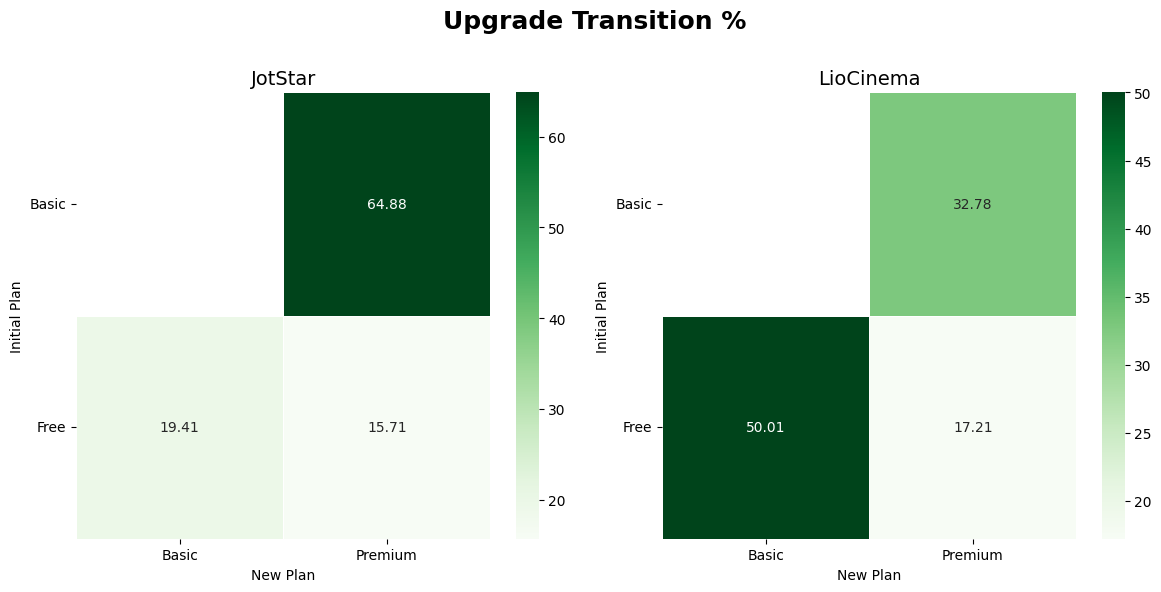

In [37]:
# Upgrade Transition %
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

upgrade_subscription_plan_transition(ax[0], js_subscribers, 'JotStar')
upgrade_subscription_plan_transition(ax[1], lc_subscribers, 'LioCinema')

fig.suptitle("Upgrade Transition %", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- JotStar users see more value in Premium than LioCinema users
- LioCinema users are more likely to jump from free to basic

#### **3. Monthly Upgrade Rate**

In [38]:
def monthly_upgrade_rate(ax, data, title):
    df_upgraded = data[(data['plan_change_date'].notna()) & 
        (data['new_subscription_plan'].map(plan_hierarchy) > data['subscription_plan'].map(plan_hierarchy))]
    
    monthly_subscribers = data.groupby(data["subscription_date"].dt.to_period('M')).size()
    
    monthly_upgrade_subscribers = df_upgraded.groupby(df_upgraded["plan_change_date"].dt.to_period('M')).size()
    monthly_upgrade_rate = round(monthly_upgrade_subscribers*100/monthly_subscribers, 2)

    x_values = monthly_upgrade_rate.index.strftime('%b')
    y_values = monthly_upgrade_rate.values

    # Create the line plot
    ax.plot(x_values, y_values, marker='o', linestyle='-')
    
    # Add data labels
    for x, y in zip(x_values, y_values):
        ax.text(x, y, str(y), ha='center', va='bottom', fontsize=10, color='black')
    
    
    # Formatting
    ax.set_title(title, fontsize=14)
    ax.grid(True)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


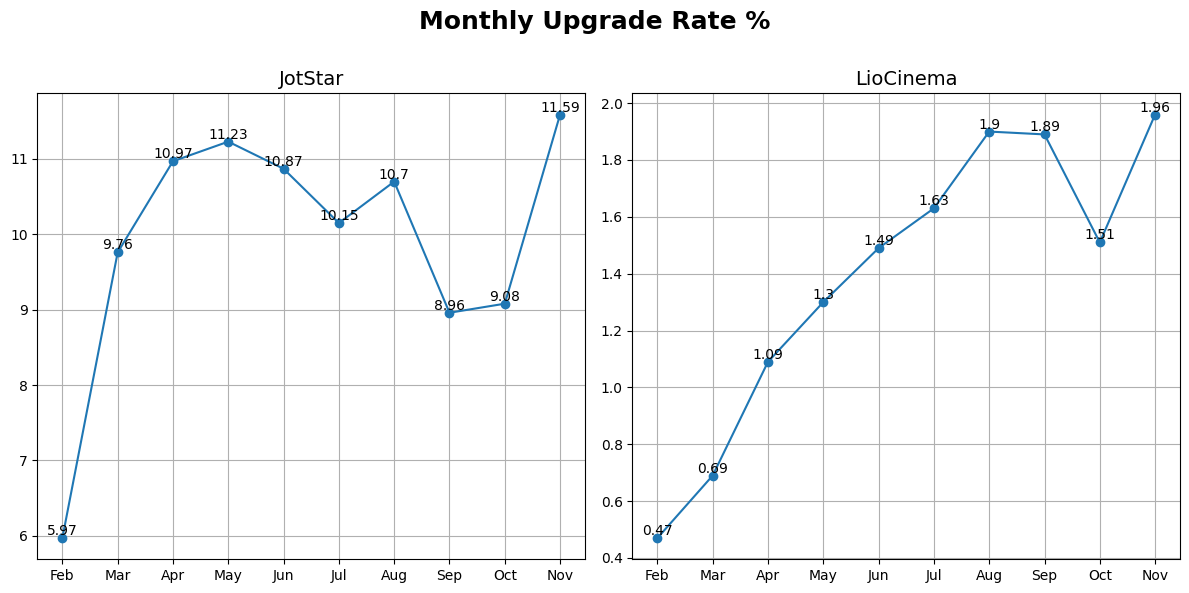

In [39]:
# Monthly Upgrade Rate %
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

monthly_upgrade_rate(ax[0], js_subscribers, 'JotStar')
monthly_upgrade_rate(ax[1], lc_subscribers, 'LioCinema')

fig.suptitle("Monthly Upgrade Rate %", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- JotStar's Growth Trend is Stronger and More Volatile
  - Upgrade rates peaked in May and November. A significant decline in September (8.96%), but it recovered in October and increased again in November
- LioCinema has a slow but steady growth pattern
  - It begins very low (0.47% in February) and slowly rises until August (1.90%)
  - The rate stabilizes around 1.5% - 1.9% by the end of the year

### **Downgrade Patterns: Understanding Subscription Downgrades**

#### **1. Age Group & City Tier Influence on Downgrades**

In [40]:
def downgrade_analysis(ax, data, title):
    # Users who downgraded
    df_downgraded = data[(data['plan_change_date'].notna()) & 
        (data['new_subscription_plan'].map(plan_hierarchy) < data['subscription_plan'].map(plan_hierarchy))]

    # Count total users per segment
    total_users_per_segment = data.groupby(['age_group', 'city_tier']).size().reset_index()
    total_users_per_segment.columns = ['age_group', 'city_tier', 'total_users']
    
    # Count upgraded users per segment
    downgraded_users_per_segment = df_downgraded.groupby(['age_group', 'city_tier']).size().reset_index()
    downgraded_users_per_segment.columns = ['age_group', 'city_tier', 'downgraded_users']

    # Merge data to get total and upgraded user counts
    downgrade_analysis = pd.merge(total_users_per_segment, downgraded_users_per_segment, on=['age_group', 'city_tier'])
    downgrade_analysis['downgrade_rate'] = round((downgrade_analysis['downgraded_users']/downgrade_analysis['total_users']) * 100, 2)
    downgrade_analysis.set_index(['age_group', 'city_tier'], inplace=True)

    sns.heatmap(downgrade_analysis['downgrade_rate'].unstack(), annot=True, fmt='', cmap='Reds', linewidths=0.5, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(rotation=0)

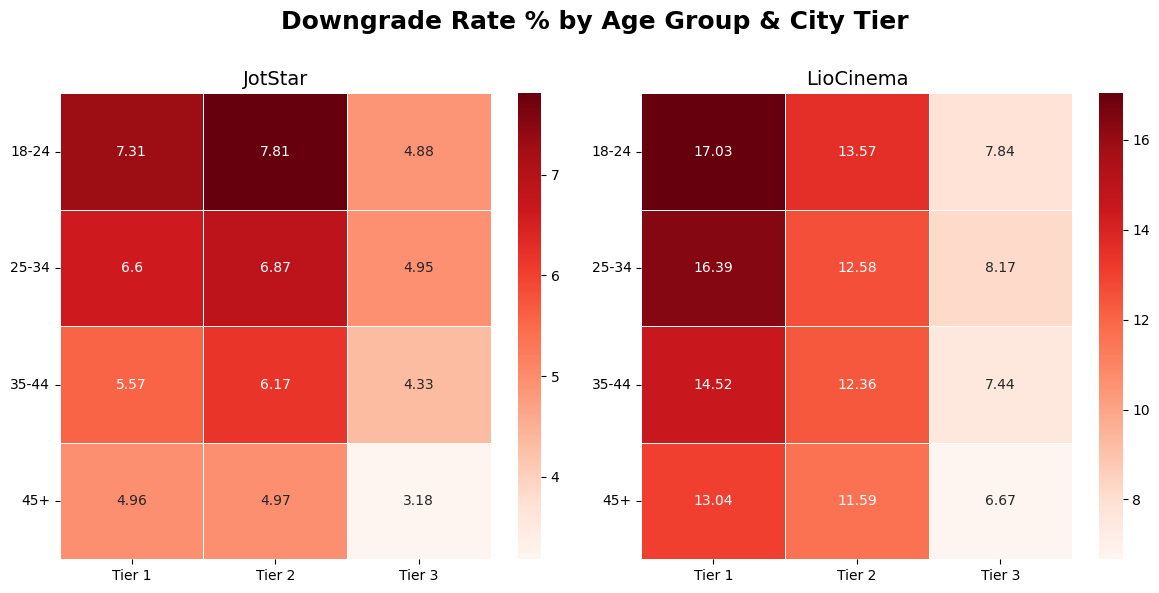

In [41]:
# Downgrade Rate % by Age Group & City Tier
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

downgrade_analysis(ax[0], js_subscribers, 'JotStar')
downgrade_analysis(ax[1], lc_subscribers, 'LioCinema')

fig.suptitle("Downgrade Rate % by Age Group & City Tier", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- JotStar has a lower downgrade rate compared to LioCinema
- Younger users have the highest downgrade rates on both platforms
- Downgrade rates are lower in Tier 3 cities, particularly for JotStar

#### **2. Downgrade Subscription Transition %**

In [42]:
def downgrade_subscription_plan_transition(ax, data, title):
    # Users who downgraded
    df_downgraded = data[(data['plan_change_date'].notna()) & 
        (data['new_subscription_plan'].map(plan_hierarchy) < data['subscription_plan'].map(plan_hierarchy))]
    
    sns.heatmap(
        round((df_downgraded[['subscription_plan', 'new_subscription_plan']].value_counts(normalize=True)*100),2).unstack(),
        annot=True, fmt='', cmap='Reds', linewidths=0.5, ax=ax
    )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('New Plan')
    ax.set_ylabel('Initial Plan')
    ax.tick_params(rotation=0)

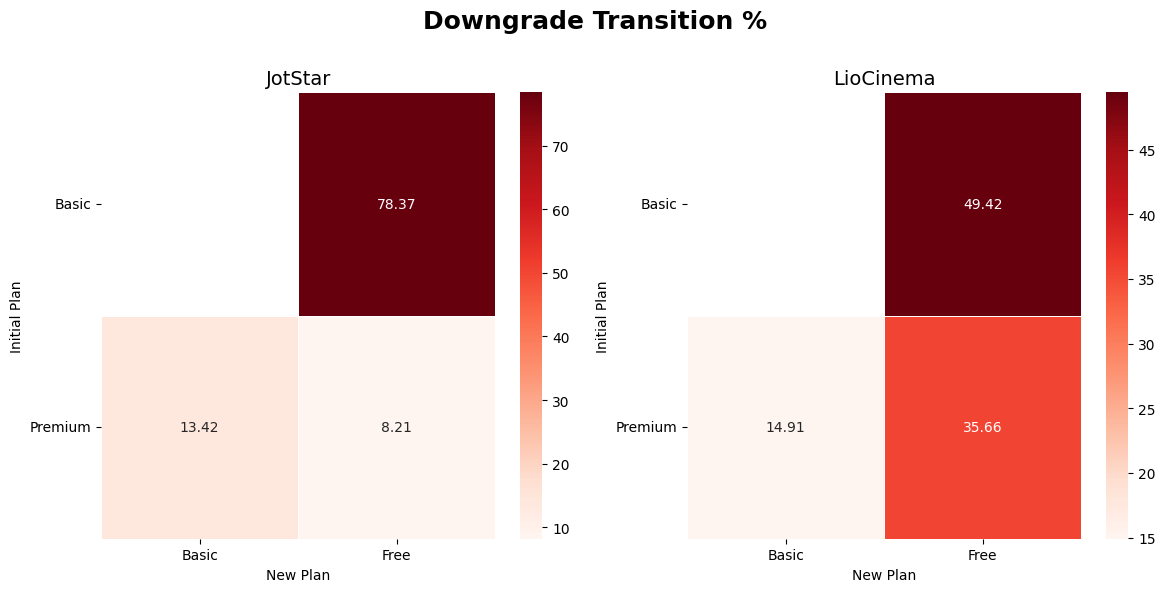

In [43]:
# Downgrade Transition %
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

downgrade_subscription_plan_transition(ax[0], js_subscribers, 'JotStar')
downgrade_subscription_plan_transition(ax[1], lc_subscribers, 'LioCinema')

fig.suptitle("Downgrade Transition %", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- JotStar Basic Users are more likely to downgrade compared to LioCinema Basic Users (Basic → Free)
- LioCinema Premium users are dropping their subscription (Premium → Free) rather than switching to Basic, showing dissatisfaction

#### **3. Monthly Downgrade Rate**

In [44]:
def monthly_downgrade_rate(ax, data, title):
    df_downgraded = data[(data['plan_change_date'].notna()) & 
        (data['new_subscription_plan'].map(plan_hierarchy) < data['subscription_plan'].map(plan_hierarchy))]
    
    monthly_subscribers = data.groupby(data["subscription_date"].dt.to_period('M')).size()
    
    monthly_downgrade_subscribers = df_downgraded.groupby(df_downgraded["plan_change_date"].dt.to_period('M')).size()
    monthly_downgrade_rate = round(monthly_downgrade_subscribers*100/monthly_subscribers, 2)
    
    x_values = monthly_downgrade_rate.index.strftime('%b')
    y_values = monthly_downgrade_rate.values

    # Create the line plot
    ax.plot(x_values, y_values, marker='o', linestyle='-')
    
    # Add data labels
    for x, y in zip(x_values, y_values):
        ax.text(x, y, str(y), ha='center', va='bottom', fontsize=10, color='black')
    
    
    # Formatting
    ax.set_title(title, fontsize=14)
    ax.grid(True)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


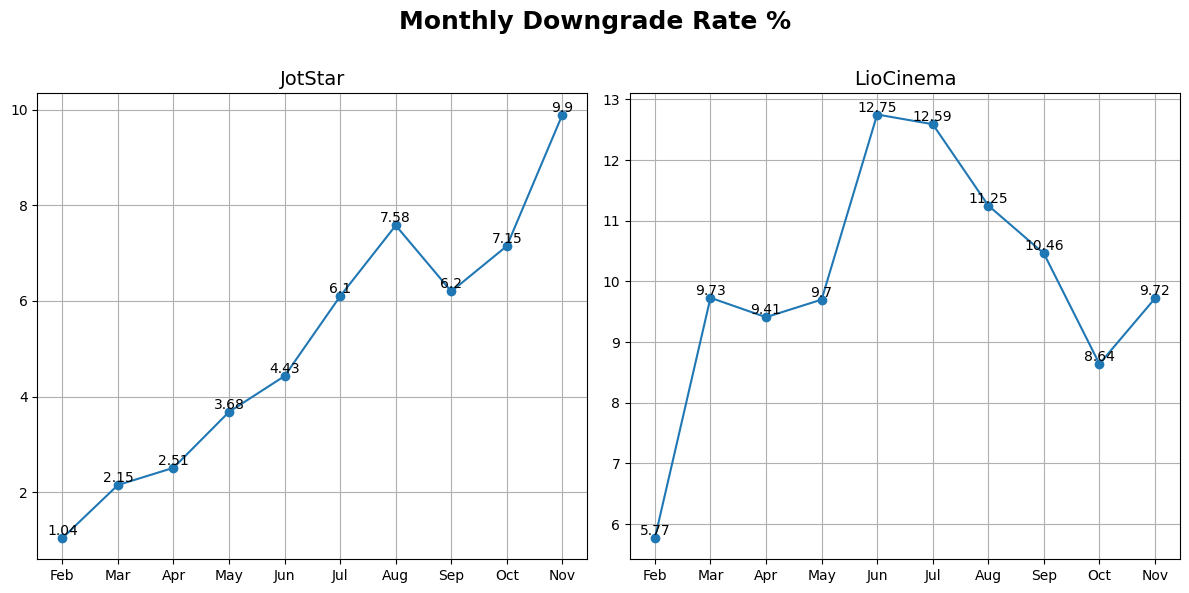

In [45]:
# Monthly Downgrade Rate %
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

monthly_downgrade_rate(ax[0], js_subscribers, 'JotStar')
monthly_downgrade_rate(ax[1], lc_subscribers, 'LioCinema')

fig.suptitle("Monthly Downgrade Rate %", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- JotStar exhibits a continuous increase in downgrades but remains lower overall, indicating higher customer retention
- LioCinema has a continuously high downgrading rate
- Higher early downgrades (Feb-May) show unhappiness with the service
- The mid-year surge in downgrades (June-July) indicates seasonal spending reduction (following summer promotions)

## <center> **Active vs. Inactive Rate Analysis** </center>  

### **Active vs. Inactive Users**

In [46]:
def active_inactive_share(ax, data, title):
    (data['status'].value_counts(normalize=True)*100).plot(kind='pie', autopct='%.2f%%', wedgeprops={'edgecolor': 'black'}, ax=ax)
    ax.set_ylabel('')
    ax.set_title(title, fontsize=12)

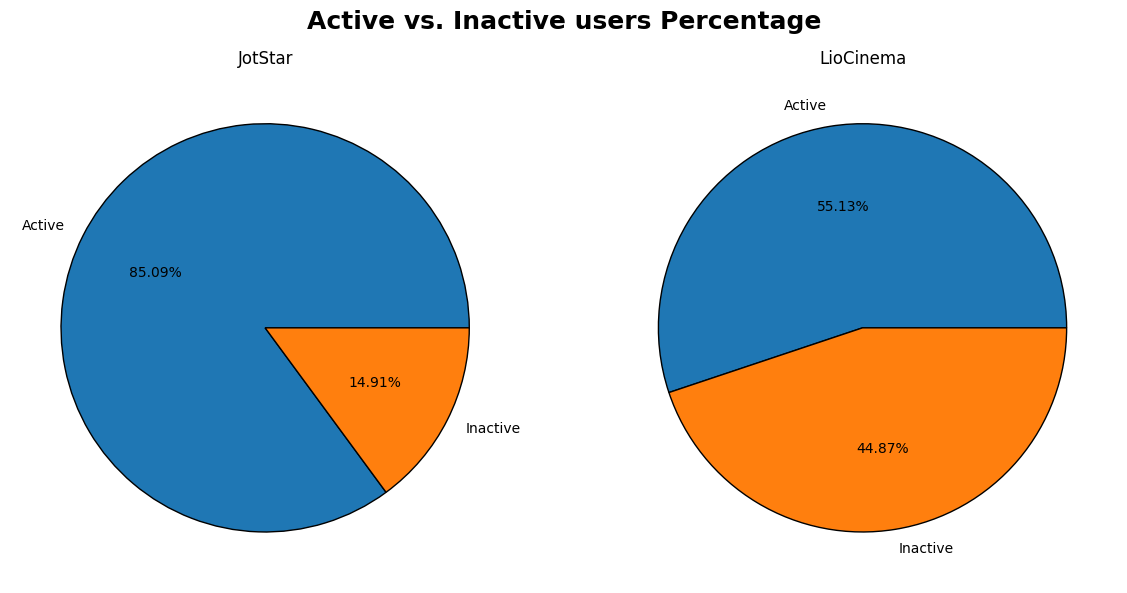

In [47]:
#  Active vs. Inactive users Percentage
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

active_inactive_share(ax[0], js_subscribers, 'JotStar')
active_inactive_share(ax[1], lc_subscribers, 'LioCinema')

fig.suptitle("Active vs. Inactive users Percentage", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- JotStar has a strong user engagement compared to LioCinema 

### **Active vs. Inactive Rate by Category**

In [48]:
def category_wise_active_inactive_rate(ax, data, category, title):
    category_pct = round((data[['status', category]].value_counts()/data.groupby(category).size())*100, 2).unstack(level=0)
    
    if category == 'subscription_plan':
        category_pct.index = pd.Categorical(category_pct.index, plan_order, ordered=True) # Change index to categorical type
        category_pct.sort_index(inplace=True) # Sort index
        
    category_pct.plot(kind='bar', stacked=True, ax=ax)
    for container in ax.containers:
        ax.bar_label(container, label_type='center')
    
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('')
    ax.tick_params(rotation=0)

#### **1. Age Group**

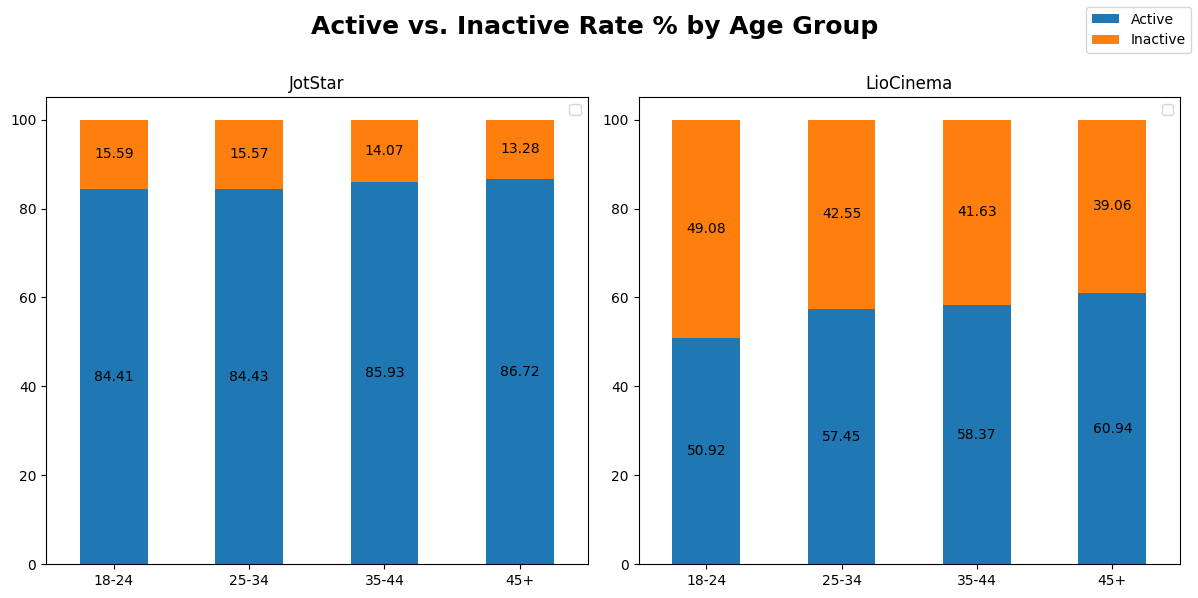

In [49]:
# Active vs. Inactive Rate % by Age Group
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

category_wise_active_inactive_rate(ax[0], js_subscribers, 'age_group', 'JotStar')
category_wise_active_inactive_rate(ax[1], lc_subscribers, 'age_group', 'LioCinema')

fig.suptitle("Active vs. Inactive Rate % by Age Group", fontsize=18, fontweight='bold')
fig.legend(['Active', 'Inactive'])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Inactive Rate drops with age group on both platforms
- JotStar demonstrates more stable engagement across ages
- LioCinema struggles to maintain all age groups, but its biggest challenge is with young people, probably due to inadequate content, aggressive acquisition but little engagement

#### **2. City Tier**

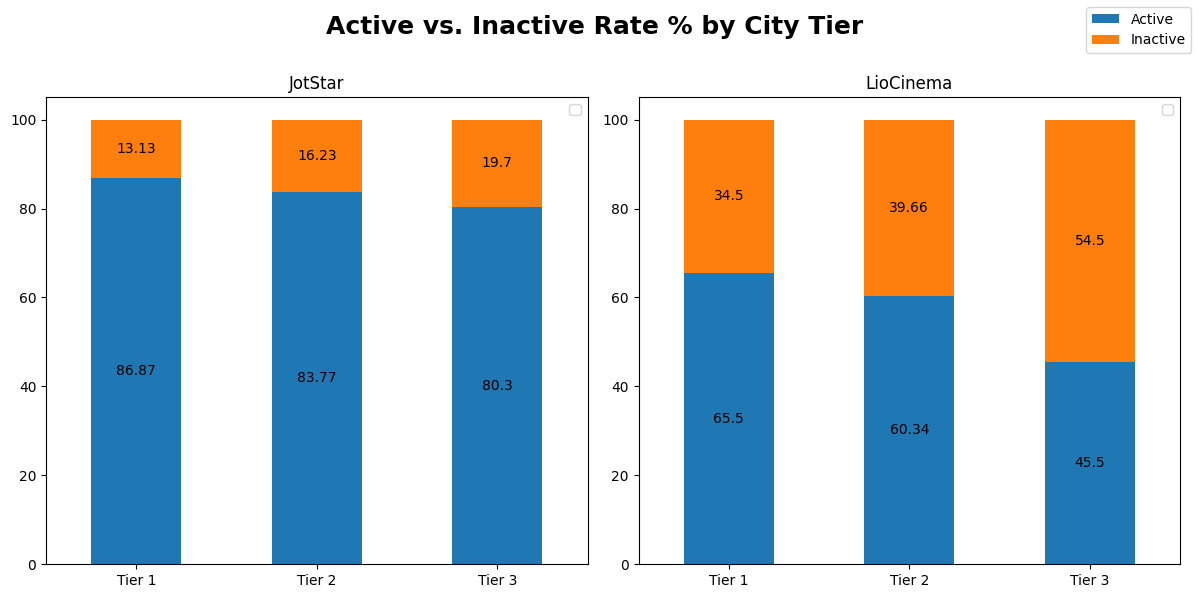

In [50]:
# Active vs. Inactive Rate % by City Tier
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

category_wise_active_inactive_rate(ax[0], js_subscribers, 'city_tier', 'JotStar')
category_wise_active_inactive_rate(ax[1], lc_subscribers, 'city_tier', 'LioCinema')

fig.suptitle("Active vs. Inactive Rate % by City Tier", fontsize=18, fontweight='bold')
fig.legend(['Active', 'Inactive'])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Higher Inactivity in Lower-Tier Cities (Tier 3 > Tier 2 > Tier 1) suggests that engagement is stronger in urban areas & weak in smaller cities, likely due to factors like affordability, internet quality, or brand reach
- LioCinema might be acquiring users aggressively but struggling to retain them, while JotStar despite its low presence in Tier 3, retains better


#### **3. Subscription Plan**

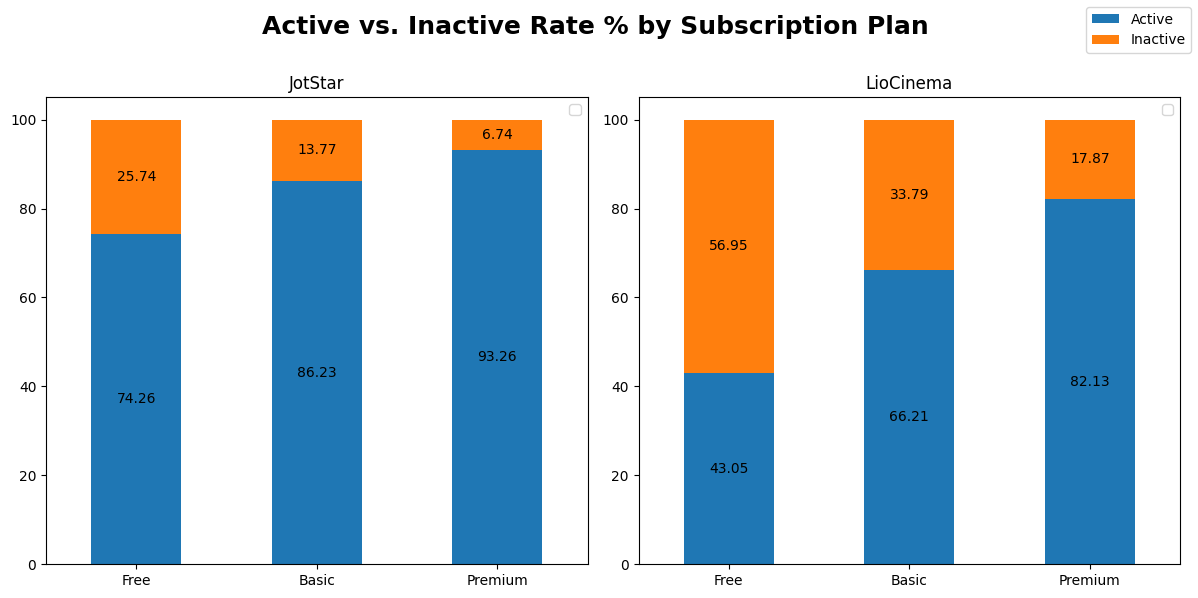

In [51]:
# Active vs. Inactive Rate % by Subscription Plan
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

category_wise_active_inactive_rate(ax[0], js_subscribers, 'subscription_plan', 'JotStar')
category_wise_active_inactive_rate(ax[1], lc_subscribers, 'subscription_plan', 'LioCinema')

fig.suptitle("Active vs. Inactive Rate % by Subscription Plan", fontsize=18, fontweight='bold')
fig.legend(['Active', 'Inactive'])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Free users are much more inactive than premium users in both platforms, indicating low engagement, maybe due to limited features, ads, or lack of investment in the service
- Premium users have the lowest inactivity rates in both LioCinema (17.87%) and JotStar (6.74%)
- LioCinema struggles with engagement across all plans

### **Monthly Inactivity Patterns**

In [52]:
def month_wise_inactive_rate(ax, data, title):
    monthly_subscribers = data.groupby(data["subscription_date"].dt.to_period('M')).size()
    
    inactive_users = data[data['status'] == 'Inactive']
    monthly_inactive_subscribers = inactive_users.groupby(inactive_users["last_active_date"].dt.to_period('M')).size()
    monthly_inactive_rate = round(monthly_inactive_subscribers*100/monthly_subscribers, 2)

    x_values = monthly_inactive_rate.index.strftime('%b')
    y_values = monthly_inactive_rate.values
    
    # Create the line plot
    ax.plot(x_values, y_values, marker='o', linestyle='-')
    
    # Add data labels
    for x, y in zip(x_values, y_values):
        ax.text(x, y, str(y), ha='center', va='bottom', fontsize=10, color='black')
    
    
    # Formatting
    ax.set_title(title, fontsize=14)
    ax.grid(True)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


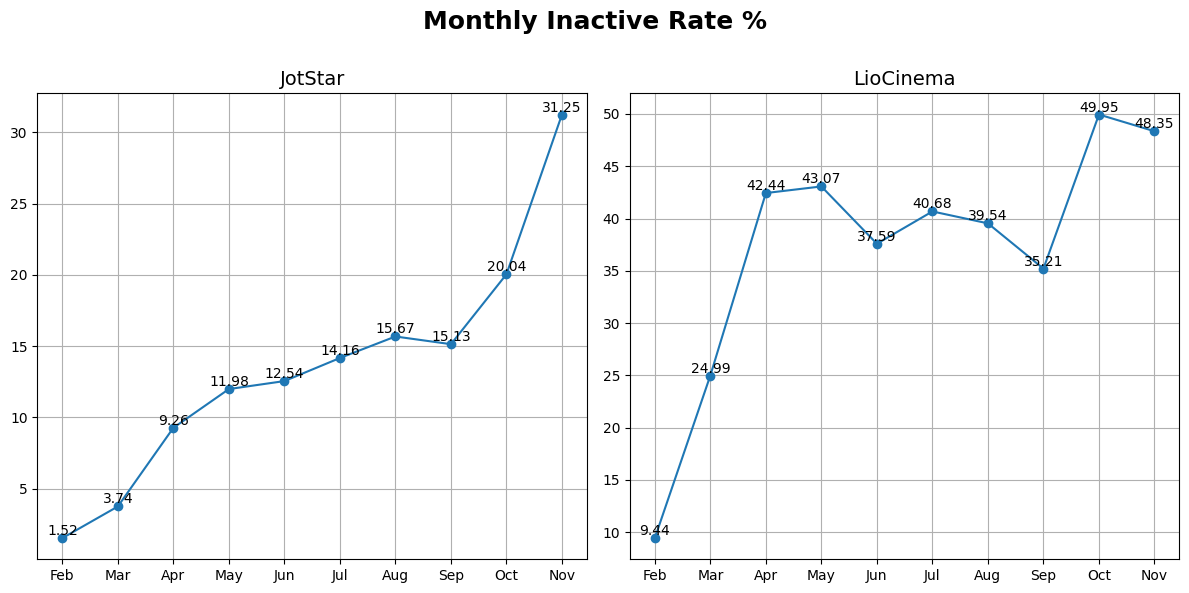

In [53]:
# Monthly Inactive Rate %
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

month_wise_inactive_rate(ax[0], js_subscribers, 'JotStar')
month_wise_inactive_rate(ax[1], lc_subscribers, 'LioCinema')

fig.suptitle("Monthly Inactive Rate %", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- Inactive rates increase month over month for both platforms, high in October & November
- JotStar starts low (1.52% in February) and increases to 31.25% in November
- LioCinema inactivity is extremely high from the start, reaching 42.44% in April and peaking at 49.95% in October

### **Inactivity Correlation**

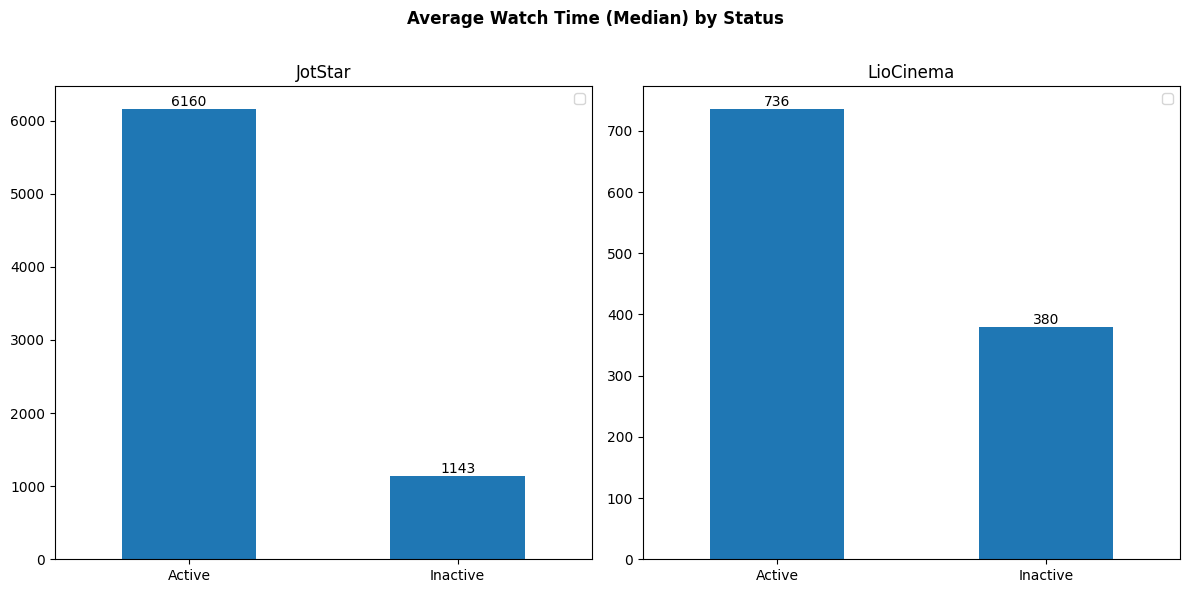

In [54]:
# Average Watch Time by Status

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

watch_time_distribution(ax[0], js_merged.groupby('status')['total_watch_time_mins'].median(), 'JotStar')
watch_time_distribution(ax[1], lc_merged.groupby('status')['total_watch_time_mins'].median(), 'LioCinema')

fig.suptitle("Average Watch Time (Median) by Status", fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- There's a strong correlation between watch time & inactivity
- JotStar has high engagement than LioCinema
- JotStar Inactive users still have 1143 mins watch time greater than LioCinema Inactive users